In [182]:
import os
import ast
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gp
import pandas as pd
import numpy as np
import pylab as pl
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source : the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [183]:
if os.getenv("PUIDATA") is None:
    print ("must set PUIDATA env variable")
else:
    print('PUIDATA env variable is set')

PUIDATA env variable is set


## Querying the asthma dismissals and grouping by zip code

In [184]:
facilityQuery = '''SELECT
COUNT(*) as count, zipcodes
FROM nycasthmasdismissals
GROUP BY zipcodes
    '''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [185]:
facilities.rename(columns={'zipcodes': 'ZIPCODE'}, inplace=True)
facilities.head()

,count,ZIPCODE
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


## Reading zip code data that was uploaded manually to PUIdata

#### from here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u?category=Business&view_name=Zip-Code-Boundaries

In [186]:
zipcodes = gp.read_file(os.getenv('PUIDATA') + "/" + "ZIP_CODE_040114.shp")
zipcodes.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


## Eliminating the columns we don't need in zip code data

In [187]:
zipcodes.columns

Index([      u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
       u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
            u'STATE',    u'ST_FIPS',        u'URL',    u'ZIPCODE',
         u'geometry'],
      dtype='object')

In [188]:
zipcodes.drop([u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
       u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
            u'STATE',    u'ST_FIPS',        u'URL'], axis=1, inplace=True)

In [189]:
zipcodes.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


## Merge
#### didn't work at first so Geoff Perrin suggested I change the column data type to string

In [190]:
type(zipcodes['ZIPCODE'])

pandas.core.series.Series

In [191]:
type(facilities['ZIPCODE'])

pandas.core.series.Series

In [192]:
zipcodes.ZIPCODE = zipcodes.ZIPCODE.astype(str)
facilities.ZIPCODE = facilities.ZIPCODE.astype(str)

In [193]:
merge = facilities.merge(zipcodes, how='inner', on='ZIPCODE')
merge.head()

,count,ZIPCODE,geometry
0,1699,10461,"POLYGON ((1029230.779448971 251468.9475710541,..."
1,405,11373,"POLYGON ((1015508.538520813 204353.9663418829,..."
2,1698,10451,"POLYGON ((1002809.989770979 240846.5980808884,..."
3,220,11691,"POLYGON ((1054519.887991399 162245.7592198849,..."
4,246,11375,"POLYGON ((1024087.848133817 207717.1410459727,..."


In [194]:
merge.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
merge.head()

,count,zipcode,geometry
0,1699,10461,"POLYGON ((1029230.779448971 251468.9475710541,..."
1,405,11373,"POLYGON ((1015508.538520813 204353.9663418829,..."
2,1698,10451,"POLYGON ((1002809.989770979 240846.5980808884,..."
3,220,11691,"POLYGON ((1054519.887991399 162245.7592198849,..."
4,246,11375,"POLYGON ((1024087.848133817 207717.1410459727,..."


## Creating centroid points from polygons
#### help from Nicola Macchitella

In [195]:
mergegdf = gp.GeoDataFrame(merge)

In [196]:
mergegdf['geometry']=mergegdf.geometry.centroid
mergegdf.rename(columns={'geometry': 'center'}, inplace=True)

In [197]:
mergegdf.head()

,count,zipcode,center
0,1699,10461,POINT (1028292.72437689 247902.4282787614)
1,405,11373,POINT (1017941.215480481 208485.1046661779)
2,1698,10451,POINT (1005358.961284301 238316.0675161843)
3,220,11691,POINT (1050360.772370908 158235.4624321515)
4,246,11375,POINT (1026858.206454871 201880.2234817908)


don't need the next three cells, was an experiment

In [198]:
mergegdf.center[0].x

1028292.72437689

In [199]:
def getX(pt):
    return pt.x
def getY(pt):
    return pt.y

In [200]:
#centroidlist_x=map(getX,mergegdf['center'].centroid)
#centroidlist_y=map(getY,mergegdf['center'].centroid)

## Creating 3d numpy array
#### Geoff suggested the for loop

In [201]:
krigdata = np.zeros((len(mergegdf),3))

In [202]:
krigdata[:,0] = mergegdf['count']
for i in range(len(krigdata)):
    krigdata[:,1][i] = mergegdf['center'][i].x
    krigdata[:,2][i] = mergegdf['center'][i].y

## Plotting 3d array with lat and lon as x and y axes plus counts as color

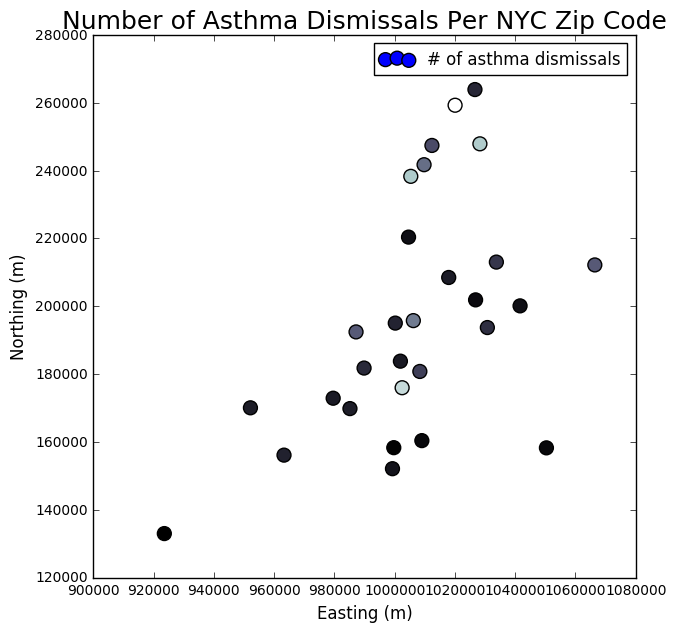

In [210]:
pl.figure(figsize=(7,7))
pl.scatter(krigdata[:,1], krigdata[:,2], c=krigdata[:,0], s=100, cmap='bone', label=('# of asthma dismissals'))
pl.xlabel("Easting (m)", fontsize=12)
pl.ylabel("Northing (m)", fontsize=12)
pl.title("Number of Asthma Dismissals Per NYC Zip Code", fontsize=18)
pl.legend()
# legend is not great - really need to show what color shades mean (quantities, ranges)

Figure 1: dots are centroids of NYC zip codes included in the asthma data, shade indicates the number of asthma dismissals; I'm assuming darker means more

In [212]:
squareform?

In [213]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [214]:
print np.array([[0,1,2],[1,2,4],[0,1,3],[3,4,5]])
#print SVh_vctzd( np.array([[0,1,2],[1,2,4],[0,1,3],[3,4,5]]), 1, 0.2 )
print SVh( np.array([[0,1,2],[1,2,4],[0,1,3],[3,4,5]]), 1, 0.2 )

[[0 1 2]
 [1 2 4]
 [0 1 3]
 [3 4 5]]
nan


In [216]:
mysv = SVh(krigdata, 1000, 500)

In [217]:
%timeit -n 1000 mysv = SVh(krigdata, 1000, 500)

1000 loops, best of 3: 663 µs per loop


In [218]:
print  SVh(krigdata, 1000, 500 )

1313444550.85


In [219]:
%timeit -n 1000 mysv = SVh_vctzd(krigdata, 1000, 500 )

1000 loops, best of 3: 158 µs per loop


In [220]:
print  SVh_vctzd(krigdata, 1000, 500 )

1313444550.85


In [221]:
lag = 100
mysv = SV(krigdata, np.arange(1, 10000, lag), 500 )
print mysv

[[  1.00000000e+00   1.01000000e+02   2.01000000e+02   3.01000000e+02
    4.01000000e+02   5.01000000e+02   6.01000000e+02   7.01000000e+02
    8.01000000e+02   9.01000000e+02   1.00100000e+03   1.10100000e+03
    1.20100000e+03   1.30100000e+03   1.40100000e+03   1.50100000e+03
    1.60100000e+03   1.70100000e+03   1.80100000e+03   1.90100000e+03
    2.00100000e+03   2.10100000e+03   2.20100000e+03   2.30100000e+03
    2.40100000e+03   2.50100000e+03   2.60100000e+03   2.70100000e+03
    2.80100000e+03   2.90100000e+03   3.00100000e+03   3.10100000e+03
    3.20100000e+03   3.30100000e+03   3.40100000e+03   3.50100000e+03
    3.60100000e+03   3.70100000e+03   3.80100000e+03   3.90100000e+03
    4.00100000e+03   4.10100000e+03   4.20100000e+03   4.30100000e+03
    4.40100000e+03   4.50100000e+03   4.60100000e+03   4.70100000e+03
    4.80100000e+03   4.90100000e+03   5.00100000e+03   5.10100000e+03
    5.20100000e+03   5.30100000e+03   5.40100000e+03   5.50100000e+03
    5.60100000e+03  

## Plotting Semivariogram

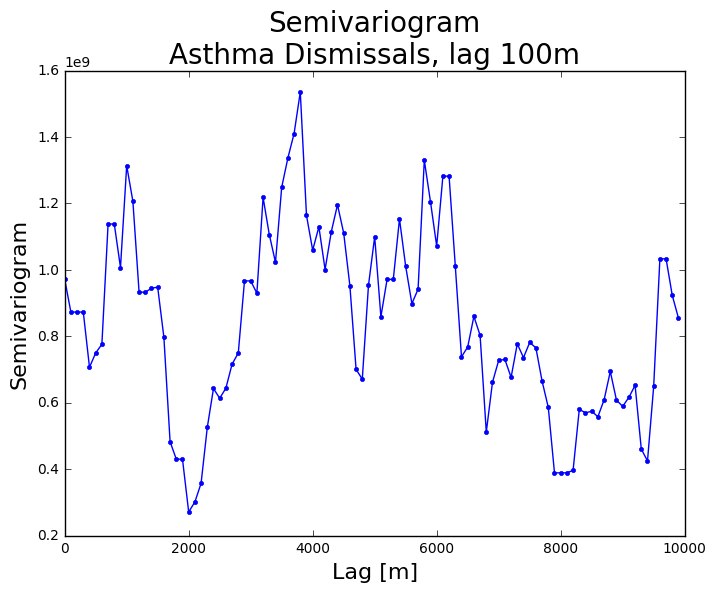

In [227]:
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0, 10500, lag)
#mysv = SV( x, hs, bw )
pl.figure(figsize=(8,6))
pl.plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [m]', fontsize=16)
pl.ylabel('Semivariogram', fontsize=16)
pl.title('Semivariogram\nAsthma Dismissals, lag %dm'%lag, fontsize=20) 

Figure 2: a semivariogram (similarity) of asthma dismissals from hospitals in NYC; it's clear there's no relationship; this is probably because people don't necessarily go to hospitals near where they're getting sick (breathing) and we haven't normalized for the size of the hospital (total number of patients); with no spatial relationship, we can't fit a model to the data, so we can't use kriging to extrapolate missing points

## Creating model functions (just to show how unhelpful the models are)

In [238]:
# different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

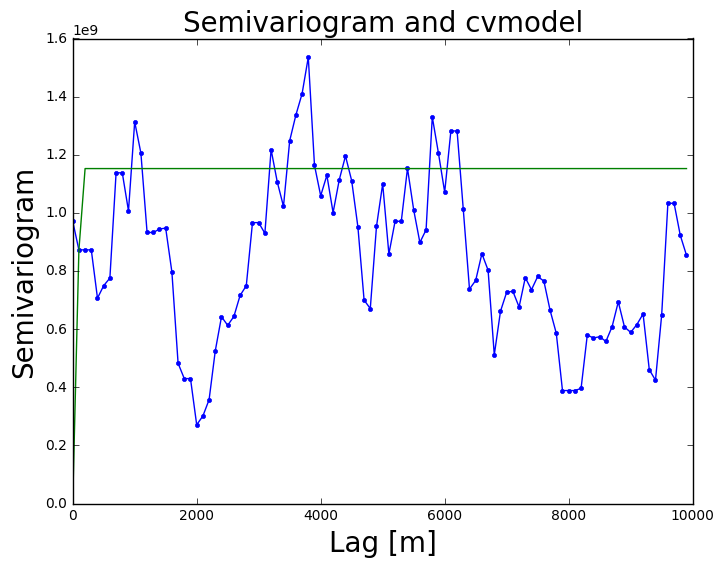

In [232]:
bw = 500
pl.figure(figsize=(8,6))
sp = cvmodel(krigdata, model=spherical, hs=np.arange(0,10000, 100 ), bw=bw)
#print sp(mysv[0])
sphere = sp(mysv[0])
pl.plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Semivariogram and cvmodel', fontsize=20) ;

Figure 3: obviously the model doesn't fit, so we can't krige anything